In [44]:
import splitfolders
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from collections import OrderedDict
from datetime import datetime

## Train, validation and test data

I split my data into 80% training, 10% validation and 10% testing data.

In [4]:
DATA_DIR = "../img/Dataset/"
OUTPUT_DIR = "../img/output/"

train_size = 0.8
val_size = 0.1
test_size = 0.1

splitfolders.ratio(
            DATA_DIR,
            output=OUTPUT_DIR,
            seed=1337,
            ratio=(train_size, val_size, test_size),
        )

This means that for each class I have ~369 images to train the model, ~46 images to use for parameter tuning and another ~46 images for testing the model's accuracy.

In [16]:
import os
img_data = {}

for folder in os.listdir(OUTPUT_DIR):
    subfolder_path = OUTPUT_DIR + folder + '/'
    img_data[folder] = {}
    for subfolder in os.listdir(subfolder_path):
        img_data[folder][subfolder] = len(os.listdir(subfolder_path + subfolder))

df = pd.DataFrame.from_dict(img_data, orient='index')
df.T.plot(kind='bar')

{'test': {'Basalt': 64, 'Coal': 109, 'Granite': 63, 'Limestone': 111, 'Marble': 115, 'Quartzite': 129, 'Sandstone': 103}, 'train': {'Basalt': 383, 'Coal': 411, 'Granite': 382, 'Limestone': 416, 'Marble': 417, 'Quartzite': 438, 'Sandstone': 403}, 'val': {'Basalt': 59, 'Coal': 111, 'Granite': 61, 'Limestone': 109, 'Marble': 118, 'Quartzite': 137, 'Sandstone': 107}}


I resized and cropped all images so they will be the same size, then loaded the training, validation and testing data.

In [28]:
im_size = 224
transformation = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(im_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ])

 # Load data
train_data = datasets.ImageFolder(
    OUTPUT_DIR + "train", transform=transformation
)
val_data = datasets.ImageFolder(
    OUTPUT_DIR + "val", transform=transformation
)
test_data = datasets.ImageFolder(
    OUTPUT_DIR + "test", transform=transformation
)

# Creating data samplers and loaders:
BATCH_SIZE = 20
train_loader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True
)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(
    test_data, batch_size=BATCH_SIZE, shuffle=False
)

# Label mapping
class_mapping = train_data.class_to_idx

## Testing image classification models
There are several image classification models out there which were trained on various datasets and built with different architectures. Each model has embeddings for identifying features of images which help classify images into specific classes. I will fine-tune these models at their last layer to output the probability of each image belonging to a specfiic class. There are multiple versions denote the number of layers for that model. More layers means better accuracy but also longer training time. I have also set it to 5 epochs for time constraints.

I will compare the performance of **ResNet** and **VGG16**.

In [ ]:
def validation(model, criterion, val_loader):
    val_loss = 0
    accuracy = 0

    for images, labels in iter(val_loader):
        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)

        equality = labels.data == probabilities.max(dim=1)[1]
        accuracy += equality.type(torch.FloatTensor).mean()

    return val_loss, accuracy

In [39]:
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=50):
    plot_training = []
    plot_validation = []

    for e in range(epochs):
        model.train()
        running_loss = 0

        for images, labels in iter(train_loader):
            optimizer.zero_grad()

            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Evaluate performance of each epoch
        model.eval()

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            validation_loss, accuracy = validation(model, criterion, val_loader)

        print(
            "Epoch: {}/{}.. ".format(e + 1, epochs),
            "Training Loss: {:.3f}.. ".format(running_loss),
            "Validation Loss: {:.3f}.. ".format(
                validation_loss / len(val_loader)
            ),
            "Validation Accuracy: {:.3f}".format(accuracy / len(val_loader)),
        )

        plot_training.append(running_loss)
        plot_validation.append(validation_loss / len(val_loader))
    
    plt.plot(range(len(plot_training)), plot_training, label='training')
    plt.plot(range(len(plot_validation)), plot_validation, label='validation')
    plt.legend()
    plt.show()

    return model

In [42]:
def save_checkpoint(model, class_mapping, arch):
    """
    Input:
    arch(str): Model architecture
    """

    checkpoint = {
        "arch": arch,
        "class_to_idx": class_mapping,
        "model_state_dict": model.state_dict(),
    }

    timestamp = datetime.now().date().strftime("%Y%m%d")
    torch.save(checkpoint, f"../checkpoint/{timestamp}_{arch}.pth")

#### ResNet

A convolutional neural network (CNN) designed to scale the number of layers in deep neural networks. As neural networks gain more layers, we expect its performance to increase but it also increases the complexity of the model since we need to tune more parameters. However, the gain in accuracy drops as the model gains complexity. Instead, ResNet uses skip functions to learn the differences between layers, reducing the number of parameters. The result is a better performing model with lower complexity.

I will use the ResNet version with 50 layers. This [video](https://www.youtube.com/watch?v=GWt6Fu05voI) does an excellent job of explaining the paper introducing ResNet, if you are keen to learn more.

c:\Users\lilia\Documents\rock-classification\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1/50..  Training Loss: 194.982..  Validation Loss: 1.094..  Validation Accuracy: 0.616
Epoch: 2/50..  Training Loss: 143.558..  Validation Loss: 0.817..  Validation Accuracy: 0.719
Epoch: 3/50..  Training Loss: 127.738..  Validation Loss: 0.833..  Validation Accuracy: 0.693
Epoch: 4/50..  Training Loss: 121.885..  Validation Loss: 0.723..  Validation Accuracy: 0.750
Epoch: 5/50..  Training Loss: 115.257..  Validation Loss: 0.742..  Validation Accuracy: 0.741
Epoch: 6/50..  Training Loss: 111.881..  Validation Loss: 0.765..  Validation Accuracy: 0.747
Epoch: 7/50..  Training Loss: 107.886..  Validation Loss: 0.689..  Validation Accuracy: 0.764
Epoch: 8/50..  Training Loss: 107.136..  Validation Loss: 0.688..  Validation Accuracy: 0.754
Epoch: 9/50..  Training Loss: 102.393..  Validation Loss: 0.675..  Validation Accuracy: 0.763
Epoch: 10/50..  Training Loss: 102.080..  Validation Loss: 0.665..  Validation Accuracy: 0.760
Epoch: 11/50..  Training Loss: 94.525..  Validation Loss: 0

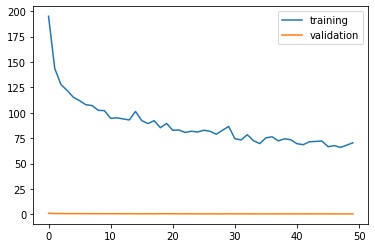

In [40]:
model = models.resnet50(weights=True)

# Freeze pretrained model parameters to avoid backpropogating through them
for parameter in model.parameters():
    parameter.requires_grad = False

# Build custom classifier
num_classes = len(class_mapping)
num_ftrs = model.fc.in_features
classifier = nn.Sequential(
    OrderedDict(
        [
            ("fc", nn.Linear(num_ftrs, num_classes)),
            ("output", nn.LogSoftmax(dim=1)),
        ]
    )
)
model.fc = classifier

# Loss function and gradient descent
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Train model
resnet_model = train_model(model, optimizer, criterion, train_loader, val_loader)

It is worth noting that the data cleaning phase made a *big* difference to our results. Before cleaning, the training accuracy remained around 45%-55% with 100 epochs. Now, the training accuracy beats that of another baseline on Kaggle with only 50 epochs!

In [45]:
save_checkpoint(resnet_model, class_mapping, 'resnet50')

#### VGGNet
CNN pretrained on over a million images from [ImageNet](https://www.image-net.org), a database of 1000 categories of labelled images. I am using the version with 16 layers.

c:\Users\lilia\Documents\rock-classification\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1/50..  Training Loss: 213.628..  Validation Loss: 1.235..  Validation Accuracy: 0.551
Epoch: 2/50..  Training Loss: 183.696..  Validation Loss: 1.087..  Validation Accuracy: 0.626
Epoch: 3/50..  Training Loss: 176.445..  Validation Loss: 1.080..  Validation Accuracy: 0.626
Epoch: 4/50..  Training Loss: 163.776..  Validation Loss: 1.009..  Validation Accuracy: 0.644
Epoch: 5/50..  Training Loss: 162.822..  Validation Loss: 1.046..  Validation Accuracy: 0.639
Epoch: 6/50..  Training Loss: 164.758..  Validation Loss: 1.097..  Validation Accuracy: 0.624
Epoch: 7/50..  Training Loss: 164.377..  Validation Loss: 1.062..  Validation Accuracy: 0.620
Epoch: 8/50..  Training Loss: 155.774..  Validation Loss: 0.972..  Validation Accuracy: 0.667
Epoch: 9/50..  Training Loss: 154.564..  Validation Loss: 0.996..  Validation Accuracy: 0.643
Epoch: 10/50..  Training Loss: 155.278..  Validation Loss: 0.957..  Validation Accuracy: 0.663
Epoch: 11/50..  Training Loss: 158.090..  Validation Loss: 

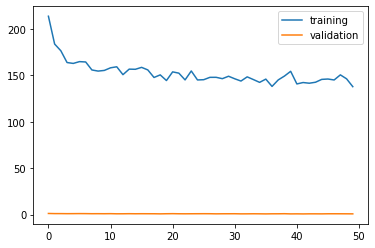

In [58]:
model = models.vgg16(weights=True)

# Freeze pretrained model parameters to avoid backpropogating through them
for parameter in model.parameters():
    parameter.requires_grad = False

# Build custom classifier
num_classes = len(class_mapping)
# num_ftrs = model.classifier.in_features
model.classifier.add_module("fc", nn.Linear(1000, num_classes))
model.classifier.add_module("output", nn.LogSoftmax(dim=1))

# Loss function and gradient descent
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Train model
vgg_model = train_model(model, optimizer, criterion, train_loader, val_loader)

In [59]:
save_checkpoint(vgg_model, class_mapping, 'vgg16')

## Testing

In [60]:
def test_model(model, test_loader):
    model.eval()

    with torch.no_grad():
        accuracy = 0

        for images, labels in iter(test_loader):
            output = model.forward(images)
            probabilities = torch.exp(output)
            equality = labels.data == probabilities.max(dim=1)[1]
            accuracy += equality.type(torch.FloatTensor).mean()

        test_accuracy = accuracy / len(test_loader)
        print("Test Accuracy: {}".format(test_accuracy))

In [61]:
test_model(resnet_model, test_loader)

Test Accuracy: 0.8480952978134155


## Code to load a checkpointed model

In [ ]:
def load_checkpoint(filepath):
    """
    Loads a checkpoint and rebuilds the model.

    Input:
    filepath(str): Relative path to model checkpoint
    """
    if os.path.exists(filepath):
        checkpoint = torch.load(filepath)

        if "resnet50" in checkpoint["arch"]:
            model = models.resnet50(pretrained=True)
        
        elif "vgg16" in checkpoint["arch"]:
            model = models.vgg16(pretrained=True)
        
        else:
            return print("Architecture not recognized.")

        for param in model.parameters():
            param.requires_grad = False
        
        model.class_to_idx = checkpoint["class_to_idx"]
        model.load_state_dict(checkpoint["model_state_dict"])
    
    else:
        print("No such checkpoint found.")

    return model